# <span style='color:blue'> LAB 6: </span>
# <span style='color:blue'> GATED RECURRENT NEURAL NETWORKS </span>

In [5]:
%matplotlib inline

import numpy as np
import math, random
import matplotlib.pyplot as plt
import torch
import seaborn as sns

## <span style='color:red'> Part 2: Gated RNN Implementation in PyTorch </span>
## <span style='color:red'> Signal Denoising </span>

In [6]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [7]:
# Sinusoidal wave generator
def sinusoidal_generator(X, signal_freq=60.):
    
    return np.sin(2 * np.pi * (X) / signal_freq)

# Adds uniform noise to the provided signal with particular noise range
def add_noise(Y, noise_range=(-0.35, 0.35)):
    
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    
    return Y + noise

# Randomly generates a noised and denoised sinusoidal sequence pair given the sequence length
# The function uses the two functions above
def sample_seq(sequence_length):
    
    random_offset = random.randint(0, sequence_length)
    X = np.arange(sequence_length)
    
    denoised_output_seq = sinusoidal_generator(X + random_offset)
    noisy_input_seq = add_noise(denoised_output_seq)
    
    return noisy_input_seq, denoised_output_seq

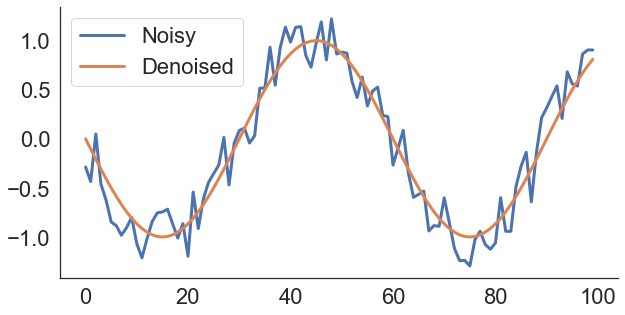

In [8]:
# Generate noised/denoised signal pair using the sample_seq function using sequence length = 100
noisy_input_seq, denoised_output_seq = sample_seq(sequence_length = 100)

plt.figure(figsize = (10, 5))

plt.plot(noisy_input_seq, label ='Noisy', linewidth = 3)
plt.plot(denoised_output_seq, label ='Denoised', linewidth = 3)
plt.legend()
sns.despine()

In [9]:
# Uses the sample_seq function above to generate n-samples of noisy and denoised sequence pairs
def create_synthetic_dataset(n_samples, sequence_length):
    
    noisy_seq_inputs = np.zeros((n_samples, sequence_length))
    denoised_seq_outputs = np.zeros((n_samples, sequence_length))
    
    for i in range(n_samples):
        
        noisy_inp, denoised_out = sample_seq(sequence_length)
        
        noisy_seq_inputs[i, :] = noisy_inp
        denoised_seq_outputs[i, :] = denoised_out
        
    return noisy_seq_inputs, denoised_seq_outputs

In [10]:
# Create 12000 pairs of noisy/denoised sequences with sequence length of 100
noisy_seq_inputs, denoised_seq_outputs = create_synthetic_dataset(n_samples = 12000, sequence_length = 100)

# Take first 8000 pairs as training (noisy: inputs, denoised: targets)
train_input_seqs, train_output_seqs = noisy_seq_inputs[:8000], denoised_seq_outputs[:8000]
# Take last 4000 pairs as testing (noisy: inputs, denoised: targets)
test_input_seqs, test_output_seqs = noisy_seq_inputs[8000:], denoised_seq_outputs[8000:]

In [11]:
# Reshape training and testing to conform to (sample_size, sequence_length, # of features) format by PyTorch
train_input_seqs = train_input_seqs.reshape((train_input_seqs.shape[0], -1, 1))
train_output_seqs = train_output_seqs.reshape((train_output_seqs.shape[0], -1, 1))

test_input_seqs = test_input_seqs.reshape((test_input_seqs.shape[0], -1, 1))
test_output_seqs = test_output_seqs.reshape((test_output_seqs.shape[0], -1, 1))

In [12]:
print("Training Input Data Shape: ", train_input_seqs.shape)
print("Training Output Data Shape: ", train_output_seqs.shape)
print("Testing Input Data Shape: ", test_input_seqs.shape)
print("Testing Output Data Shape: ", test_output_seqs.shape)

Training Input Data Shape:  (8000, 100, 1)
Training Output Data Shape:  (8000, 100, 1)
Testing Input Data Shape:  (4000, 100, 1)
Testing Output Data Shape:  (4000, 100, 1)


## Define Model

In [13]:
class Denoiser_GRU(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(Denoiser_GRU, self).__init__()
        
        # Using GRU cell with batch_first = True, i.e., we are using (sample_size, sequence_length, # of features) format
        # Bidirectional = False, so only forward context is taken
        self.gru = torch.nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                                num_layers = num_layers, 
                                batch_first = True,
                                bidirectional = False)
        
        # Decoder layer to take in GRU hidden states and output a single number (i.e. denoised value at time t)
        self.decoder = torch.nn.Linear(hidden_size, output_size) 
        
        # Uses Tanh activation to squeeze the decoder output between -1 and 1
        # Note that our dataset consists of sinusoidal between -1 and 1
        self.output_activation = torch.nn.Tanh()
        
    def forward(self, input_seq, hidden_state):
        
        # Feed gru cell with input sequence and initial hidden state
        pred, hidden = self.gru(input_seq, hidden_state)
        
        # Feed the output of the GRU (pred) to decoder layer, followed by taking the Tanh activation
        pred = self.output_activation(self.decoder(pred))
        
        return pred

## Define Hyperparameters

In [14]:
# Define our RNN sequence model. Using hidden size = 30 and single layer of GRU layer (num_layers = 1) 

denoiser_GRU = Denoiser_GRU(input_size = 1, hidden_size = 30, 
                            num_layers = 1, output_size = 1)

# Define learning rate and epochs
learning_rate = 0.0003          
epochs = 100

# Batch size for mini-batch gradient
batchsize = 300

# Using least absolute deviation loss L1Loss
# The loss function minimizes the sum of the all the absolute differences between the true value and the predicted value
# Using Adam as optimizer
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(denoiser_GRU.parameters(), lr=learning_rate)

# Attach .cuda() if running with GPU
# Make sure the displayed info matches what you specified above
denoiser_GRU

Denoiser_GRU(
  (gru): GRU(1, 30, batch_first=True)
  (decoder): Linear(in_features=30, out_features=1, bias=True)
  (output_activation): Tanh()
)

## Identify Tracked Values

In [15]:
# Empty Python list to append training loss values
train_loss_list = []

## Train Model

In [16]:
# Convert training/testing data to torch tensors
# Using .float() for both since our targets are also floating point numbers
# Attach .cuda() to use with GPU
train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

test_input_seqs = torch.from_numpy(test_input_seqs).float()
test_output_seqs = torch.from_numpy(test_output_seqs).float()

# Split the training features/targets to mini-batch size defined above
train_batches_features = torch.split(train_input_seqs, batchsize)
train_batches_targets = torch.split(train_output_seqs, batchsize)

# Total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

for epoch in range(epochs): # For each epoch
    
    for k in range(batch_split_num): # iterate through mini-batches
        
        # initialize the hidden states as None
        hidden_state = None
        
        # Feed in k-th mini-batch training features to GRU + hidden states to produce output
        pred = denoiser_GRU(train_batches_features[k], hidden_state)
        
        # zero_grad() to clear gradient buffer
        optimizer.zero_grad()
        
        # Compute loss between the GRU denoised sequence vs target training sequence
        loss = loss_func(pred, train_batches_targets[k])
        # Append loss
        train_loss_list.append(loss.item())
        
        # Backpropagation
        loss.backward()
        
        # Update weights/biases
        optimizer.step()
    
    # Print the averaged training loss (L1 Loss) throughout epoch
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

Averaged Training Loss for Epoch  0 :  0.6640275032431991
Averaged Training Loss for Epoch  1 :  0.6138820118374295
Averaged Training Loss for Epoch  2 :  0.5571029870598404
Averaged Training Loss for Epoch  3 :  0.48583086883580245
Averaged Training Loss for Epoch  4 :  0.3910095857249366
Averaged Training Loss for Epoch  5 :  0.30298657108236243
Averaged Training Loss for Epoch  6 :  0.2449182939750177
Averaged Training Loss for Epoch  7 :  0.19332304486521967
Averaged Training Loss for Epoch  8 :  0.14608425950562512
Averaged Training Loss for Epoch  9 :  0.12227707107861836
Averaged Training Loss for Epoch  10 :  0.1181791063260149
Averaged Training Loss for Epoch  11 :  0.11665756696904148
Averaged Training Loss for Epoch  12 :  0.11530890812476476
Averaged Training Loss for Epoch  13 :  0.1140890289787893
Averaged Training Loss for Epoch  14 :  0.11296015977859497
Averaged Training Loss for Epoch  15 :  0.1119024681824225
Averaged Training Loss for Epoch  16 :  0.1108971798309573

KeyboardInterrupt: 

## Visualize & Evaluate Model

In [ ]:
# Visualize training loss curve
plt.figure(figsize = (10, 5))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

In [ ]:
# Compute the L1 Loss for testing set by feeding in the test_input_seqs defined earlier to the trained GRU

with torch.no_grad():
    
    # test_prediction: Denoised test sequences processed by trained GRU
    test_prediction = denoiser_GRU(test_input_seqs, None)
    test_loss = loss_func(test_prediction, test_output_seqs).item()
    
    print("Testing Loss (Least Absolute Deviations): ", test_loss)

In [ ]:
# Let's randomly sample the test prediction generated by trained GRU vs the expected the target
# If using GPU need to attach .cpu() first before you use convert back to numpy arrays

sample_num = 1000 # Feel free to vary this number between 0 and 4000 

with torch.no_grad():
    
    plt.figure(figsize = (10, 5))
    
    plt.plot(test_prediction[sample_num].numpy(), label='RNN Denoised', linewidth = 3)
    plt.plot(test_output_seqs[sample_num].numpy(), label='Groundtruth', linewidth = 3)
    plt.legend()
    plt.title("Sample num: {}".format(sample_num))
    sns.despine()